In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox

In [23]:
series = pd.read_csv("https://raw.githubusercontent.com/SergKostarev/time-series-arima/refs/heads/main/weekly-closings-of-the-dowjones-.csv")['Close']

In [24]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [25]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


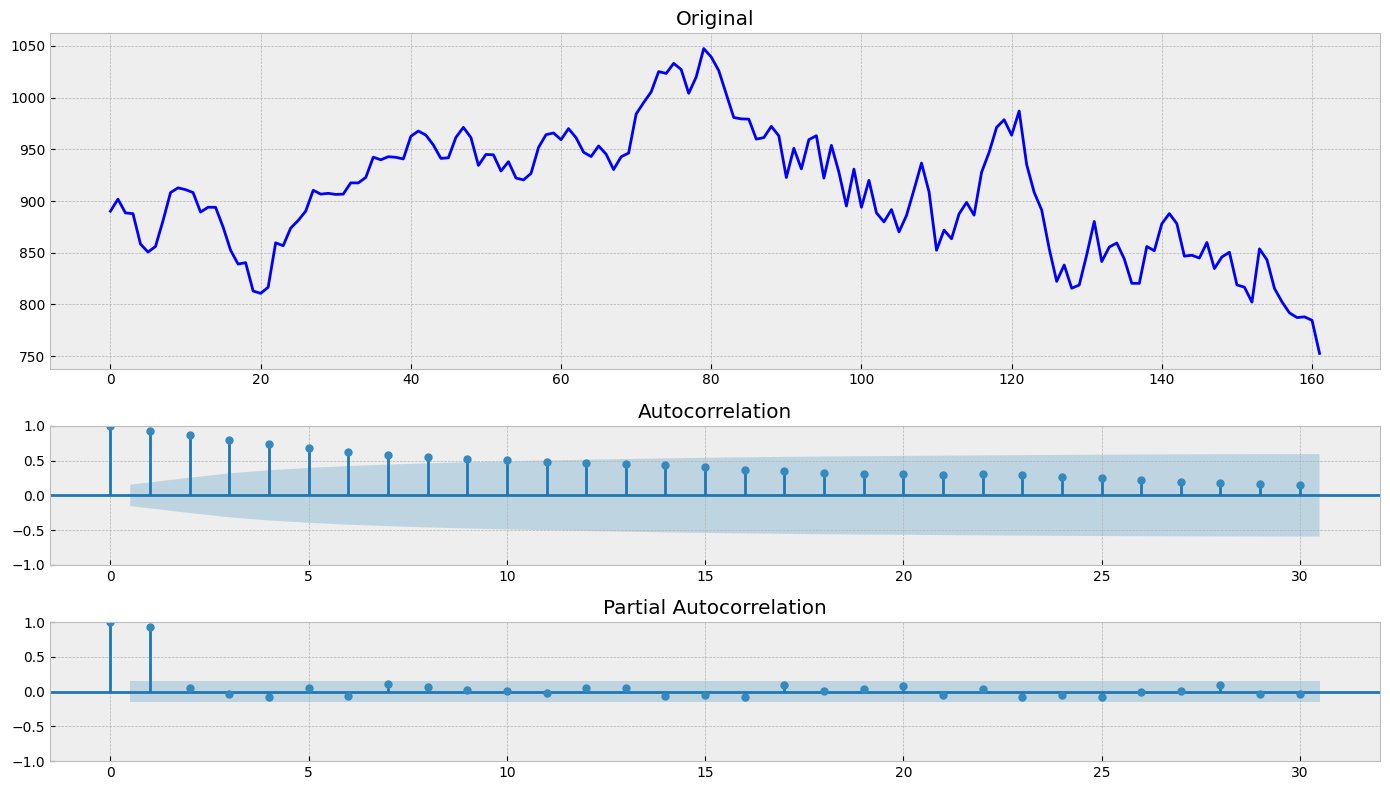

In [26]:
tsplot(series, lags=30)

In [27]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

aic: 1416.32751 | order: (2, 2, 3)
Results of Dickey-Fuller Test:
Test Statistic                 -51.719727
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


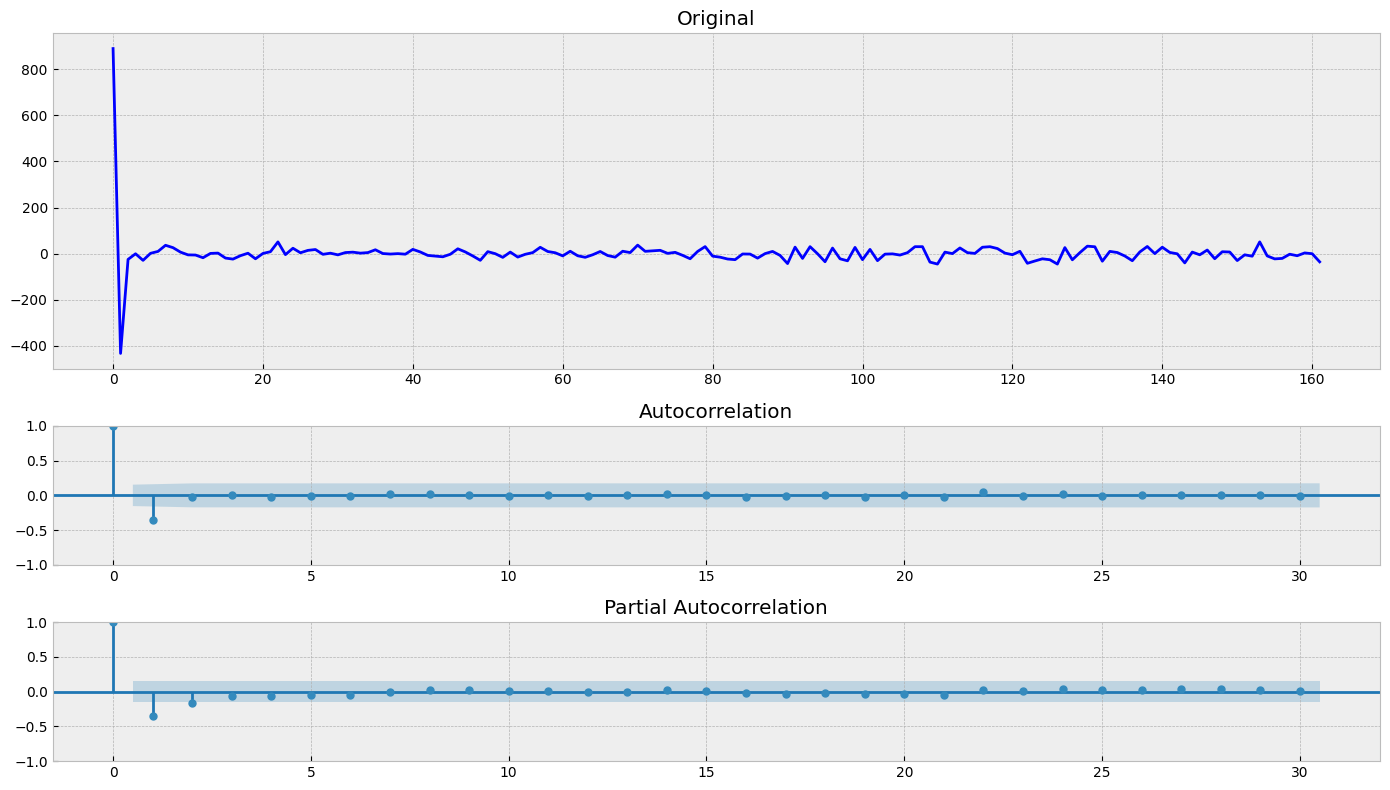

In [28]:
best_aic = np.inf
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = ARIMA(series, order=(i, d, j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

tsplot(best_mdl.resid, lags=30)

In [29]:
from statsmodels.graphics.tsaplots import plot_predict

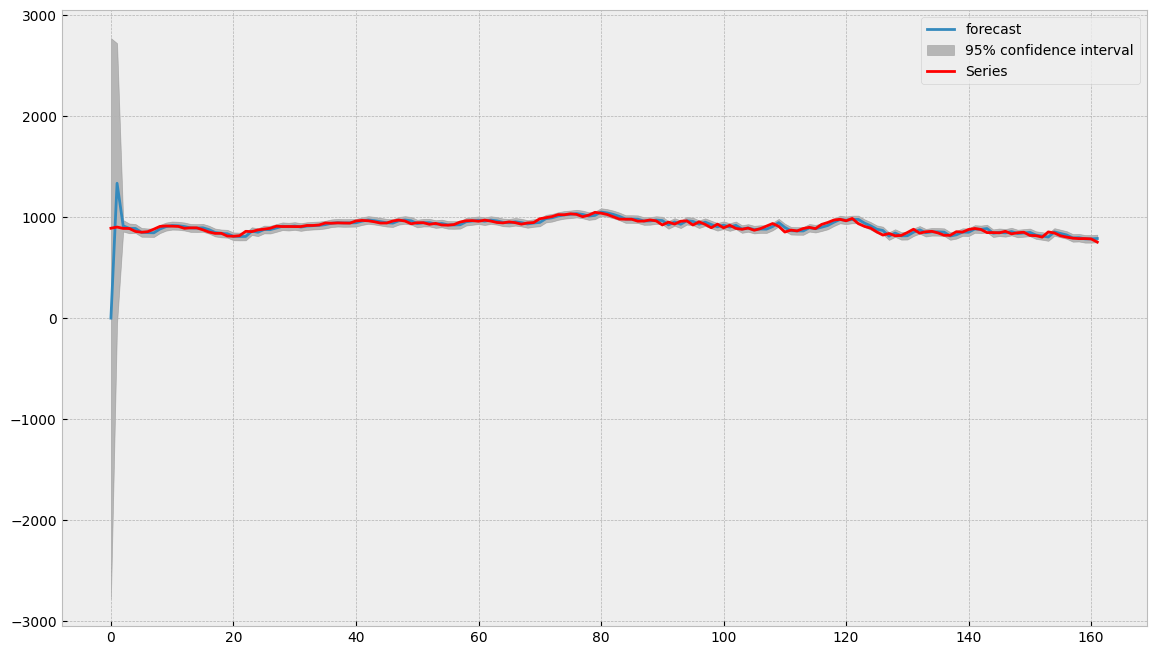

In [30]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(best_mdl, 0, len(series) - 1, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

In [31]:
series_ml = series.copy().to_frame()

In [32]:
series_ml['Time'] = np.arange(len(series.index))
series_ml['Lag_1'] = series_ml['Close'].shift(1)
series_ml.fillna(value=series_ml['Close'].mean(), inplace=True)
series_ml.head()

,Close,Time,Lag_1
0,890.19,0,907.484753
1,901.80,1,890.190000
2,888.51,2,901.800000
3,887.78,3,888.510000
4,858.43,4,887.780000


In [33]:
from sklearn.linear_model import LinearRegression

# Training data
X = series_ml.loc[:, ['Time']]  # features
y = series_ml.loc[:, 'Close']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

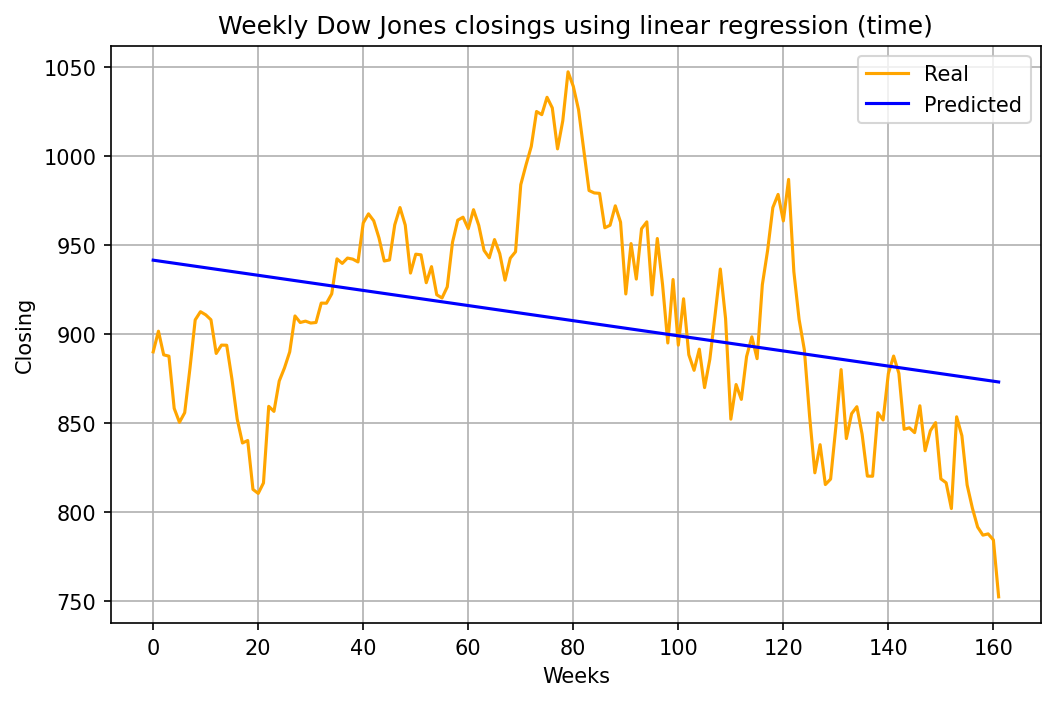

In [34]:
plt.figure(figsize=(8, 5), dpi=150)

series_ml['Close'].plot(label='Real', color='orange')
y_pred.plot(label='Predicted', color='blue')

plt.title('Weekly Dow Jones closings using linear regression (time)')
plt.xlabel('Weeks')
plt.ylabel('Closing')
plt.legend()
plt.grid(True)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -1.809310
p-value                          0.375849
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


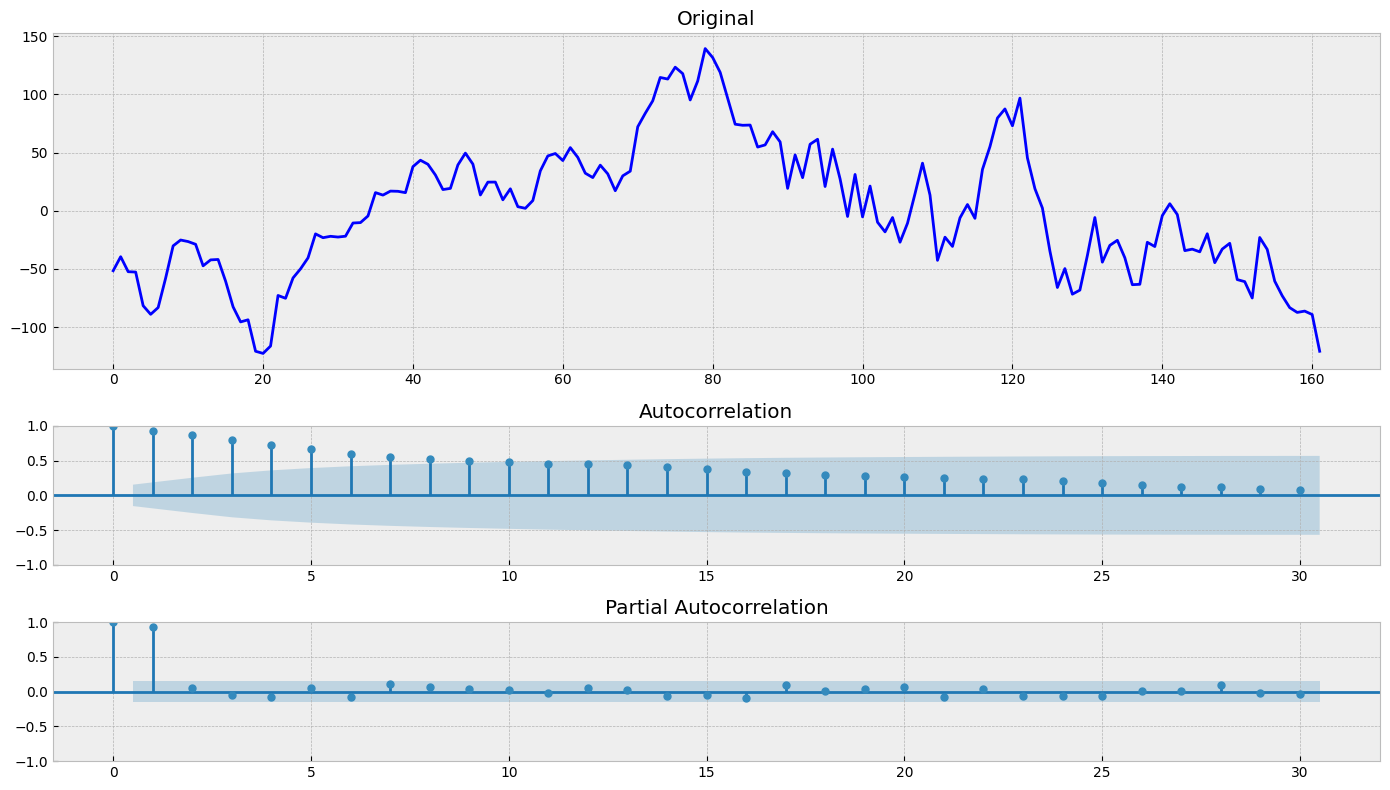

In [35]:
tsplot(series - y_pred, lags=30)

In [36]:
# Training data
X = series_ml.loc[:, ['Lag_1']]  # features

# Train the model
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

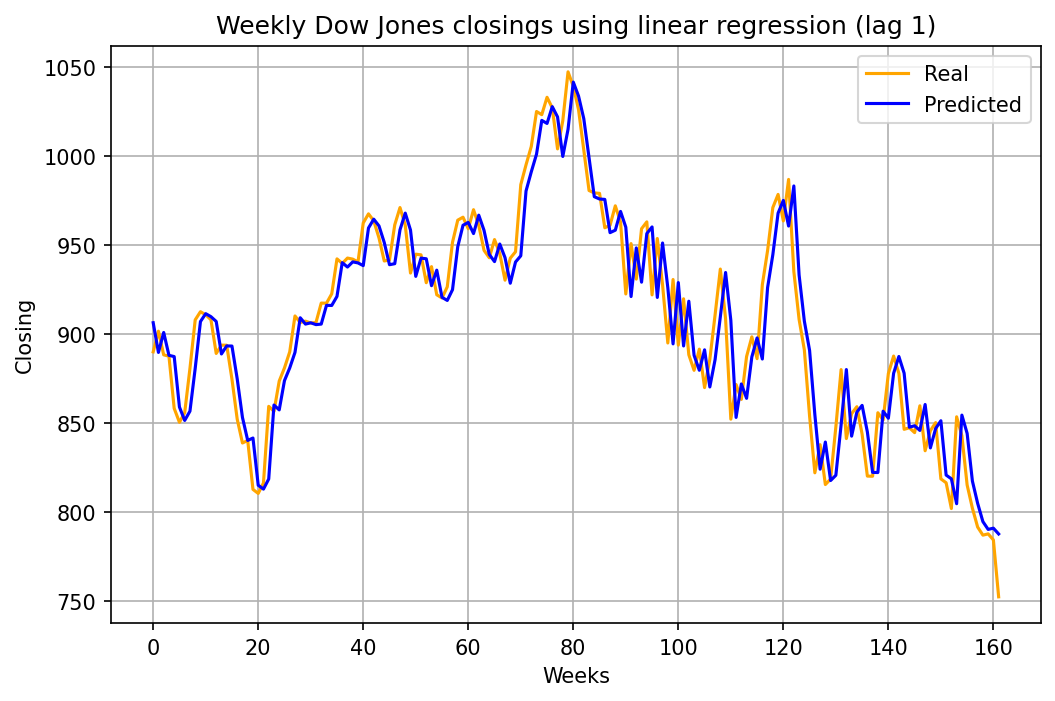

In [37]:
plt.figure(figsize=(8, 5), dpi=150)

series_ml['Close'].plot(label='Real', color='orange')
y_pred.plot(label='Predicted', color='blue')

plt.title('Weekly Dow Jones closings using linear regression (lag 1)')
plt.xlabel('Weeks')
plt.ylabel('Closing')
plt.legend()
plt.grid(True)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.280400e+01
p-value                        6.660715e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.610000e+02
Critical Value (1%)           -3.471633e+00
Critical Value (5%)           -2.879665e+00
Critical Value (10%)          -2.576434e+00
dtype: float64


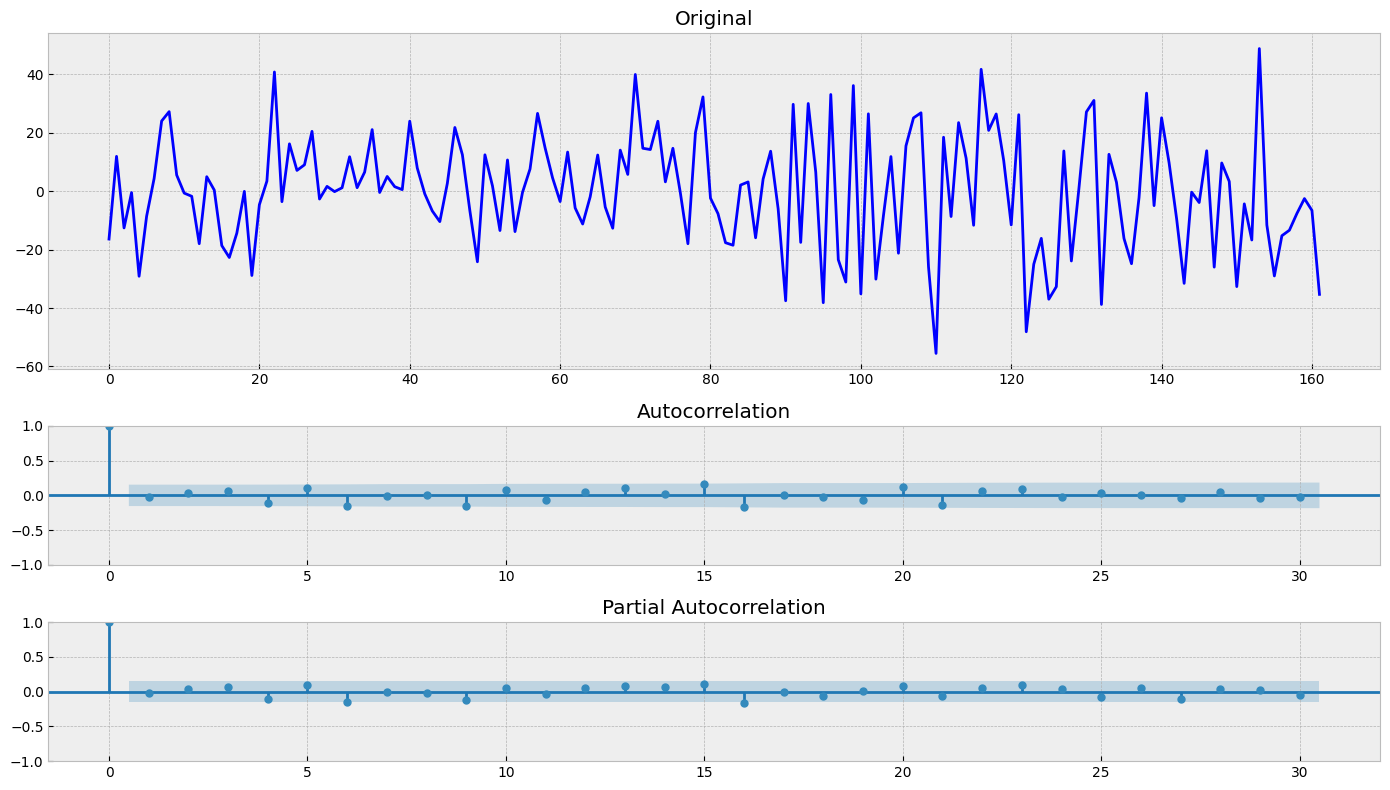

In [39]:
tsplot(series - y_pred, lags=30)

В работе рассмотрены методы описания временного ряда индекса Доу Джонса на основе моделей ARIMA и линейной регрессии. Модель ARIMA позволяет хорошо описать ряд, сделав ряд остатков стационарным.
Линейная регрессия реализована в двух вариантах: на основе лага и времени. Ряд является зависимым от времени, если его значения можно предсказать, исходя из момента их возникновения. Лаг моделирует последовательную зависимость во временном ряду - когда наблюдение можно предсказать на основе предыдущих наблюдений. В рассмотреном примере линейная регрессия на основе времени позволяет описать лишь тренд во временном ряду. Регрессия на основе лага со значением 1 также удовлетворительно описывает ряд.